In [2]:
import sys 
sys.path.append('../src/')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from scipy import stats
import config
import helper
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')

%matplotlib inline


In [14]:
# Reading the data
df = pd.read_csv(config.RAW_FILES, na_values="?")
df.head()

,age,gender,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [15]:
df.skew()

age        -0.209060
gender     -0.774935
cp         -0.841754
trestbps    0.706035
chol        1.135503
fps         1.986652
restecg     0.019900
thalach    -0.537449
exang       0.742532
oldpeak     1.269720
slope       0.508316
ca          1.189352
thal        0.244447
class       1.058496
dtype: float64

In [16]:
df.shape

(303, 14)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   gender    303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fps       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  class     303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [18]:
df.columns


Index(['age', 'gender', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'class'],
      dtype='object')

In [19]:
df.nunique()

age          41
gender        2
cp            4
trestbps     50
chol        152
fps           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
class         5
dtype: int64

In [20]:
(
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={'index': 'Features', 0: "missing_count"})
        .query('missing_count != 0')
        .style.background_gradient()
)

,Features,missing_count
11,ca,4
12,thal,2


In [21]:
df['ca'] = df['ca'].fillna('-111')
df['thal'] = df['thal'].fillna('-111')

In [22]:
(
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={'index': 'Features', 0: "missing_count"})
        .query('missing_count != 0')
        .style.background_gradient()
)

,Features,missing_count


In [23]:
sc_table = df.describe().T.style.background_gradient(cmap='viridis')
caption = "Descriptive Statistics for Numeric Columns"
sc_table.set_caption(caption)
sc_table

,count,mean,std,min,25%,50%,75%,max
age,303.000000,54.438944,9.038662,29.000000,48.000000,56.000000,61.000000,77.000000
gender,303.000000,0.679868,0.467299,0.000000,0.000000,1.000000,1.000000,1.000000
cp,303.000000,3.158416,0.960126,1.000000,3.000000,3.000000,4.000000,4.000000
trestbps,303.000000,131.689769,17.599748,94.000000,120.000000,130.000000,140.000000,200.000000
chol,303.000000,246.693069,51.776918,126.000000,211.000000,241.000000,275.000000,564.000000
fps,303.000000,0.148515,0.356198,0.000000,0.000000,0.000000,0.000000,1.000000
restecg,303.000000,0.990099,0.994971,0.000000,0.000000,1.000000,2.000000,2.000000
thalach,303.000000,149.607261,22.875003,71.000000,133.500000,153.000000,166.000000,202.000000
exang,303.000000,0.326733,0.469794,0.000000,0.000000,0.000000,1.000000,1.000000
oldpeak,303.000000,1.039604,1.161075,0.000000,0.000000,0.800000,1.600000,6.200000


### Observations from Descriptive Statistics

1. **Age**: The average age is 54.44 years, with a range from 29 to 77 years, indicating a middle-aged to older adult population.
2. **Resting Blood Pressure (trestbps)**: The mean resting blood pressure is 131.69 mm Hg, with values ranging from 94 to 200 mm Hg, showing a mix of normal and hypertensive individuals.
3. **Cholesterol (chol)**: The average cholesterol level is 246.69 mg/dL, with a wide range from 126 to 564 mg/dL, indicating high variability and some extremely high cholesterol levels.
4. **Maximum Heart Rate Achieved (thalach)**: The mean maximum heart rate is 149.61 bpm, ranging from 71 to 202 bpm, reflecting differences in cardiovascular fitness levels.
5. **ST Depression Induced by Exercise (oldpeak)**: The average ST depression is 1.04, with values from 0 to 6.2, showing that while many individuals have no depression, a significant number have higher values indicating varying degrees of exercise-induced ischemia.

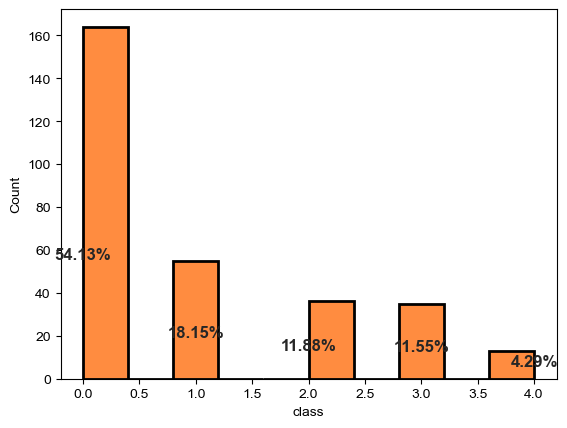

In [24]:
sns.histplot(df['class'], color='#ff6600', linewidth=2)
sns.set_theme('notebook')
plt.grid(False)
class_counts = df['class'].value_counts(normalize=True) * 100


# Annotate bars with percentages
for i, v in enumerate(class_counts):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom',fontweight='bold')

plt.show()

NameError: name 'df' is not defined

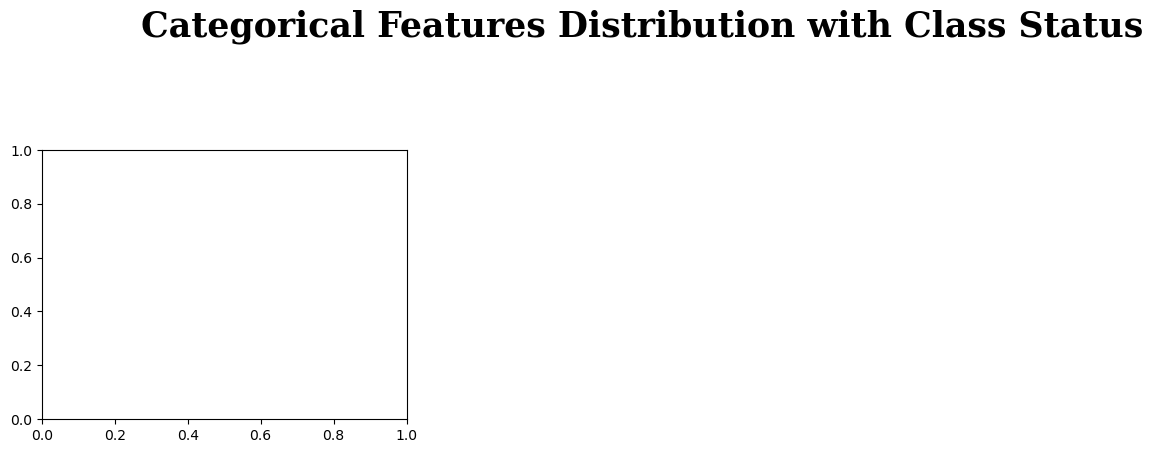

In [6]:
# Define categorical features and colors
categorical_features = ['gender', 'cp', 'fps', 'restecg', 'exang', 'slope', 'ca', 'thal', 'class']
colors = ["#153448", "#3C5B6F","#948979", "#DFD0B8", "#B5C18E"]

# Create subplots with adjusted figure size and spacing
plt.figure(figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)  # Adjust the subplot layout here
    plt.suptitle("Categorical Features Distribution with Class Status", fontsize=25, fontweight='bold', fontfamily='serif')
    sns.countplot(x=feature, hue='class', data=df, palette=colors)
    plt.title(feature, fontfamily='serif', fontsize=15, fontweight='bold')
    plt.gca().spines['left'].set_visible(False)  
    plt.gca().spines['right'].set_visible(False)  
    plt.gca().spines['top'].set_visible(False) 
    plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False) 
    plt.gca().set_ylabel('')

    # Annotate counts on each bar
    for patch in plt.gca().patches:
        height = patch.get_height()
        if height > 0:
            plt.gca().annotate('{}'.format(int(height)),
                               xy=(patch.get_x() + patch.get_width() / 2, height),
                               xytext=(0, 3), 
                               textcoords="offset points",
                               ha='center', va='bottom', fontsize=12, fontweight='light', fontfamily='serif')
    plt.grid(False)

plt.tight_layout()

plt.show()


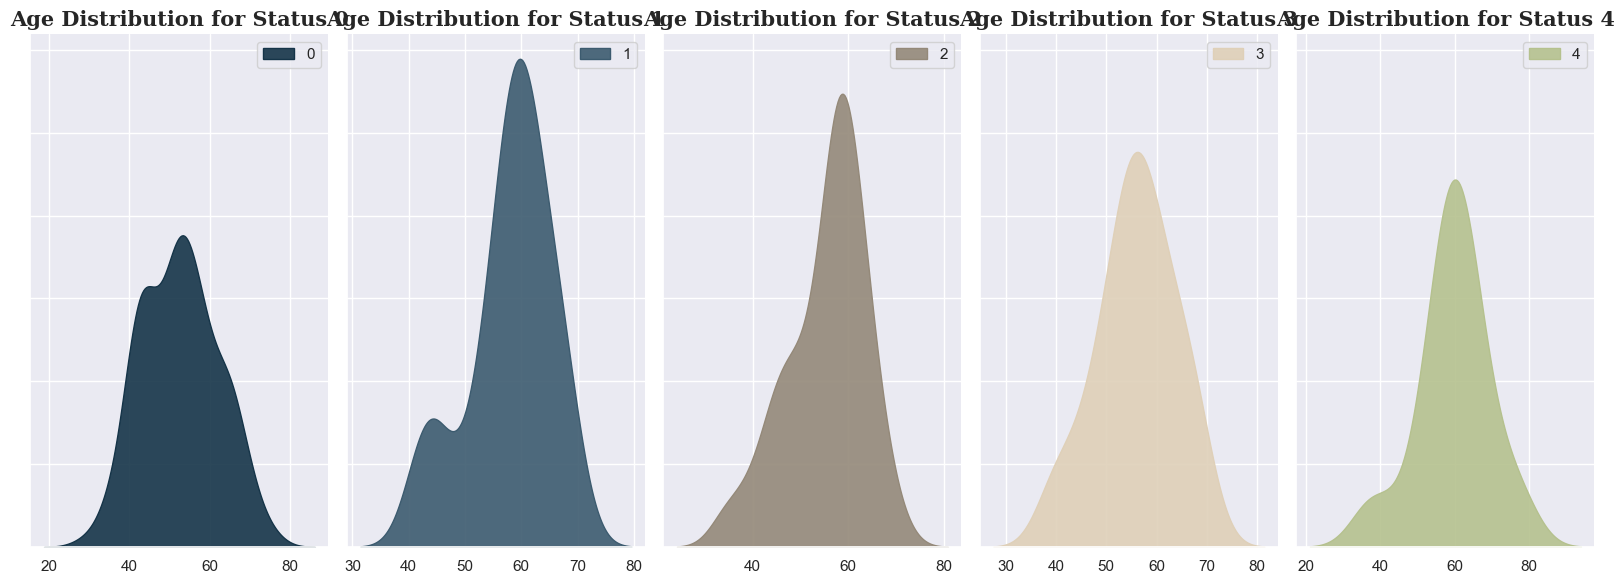

In [26]:
# Define legend labels for each status class
legend_labels = ['0', '1', '2', '3', '4']
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
# Plot KDE plots for each status class
for ax, status, color, legend_label in zip(axes, df['class'].unique(), colors, legend_labels):
    sns.kdeplot(data=df[df['class'] == status], x='age', color=color, fill=True, alpha=0.9, ax=ax)
    ax.set_title(f'Age Distribution for Status {legend_label}',fontfamily='serif', fontsize=15, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(True)  # Remove left spine
    ax.spines['right'].set_visible(False)  # Remove right spine
    ax.spines['top'].set_visible(False)  # Hide top spine
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)  # Hide left y-axis ticks and labels
    ax.legend([legend_label], loc='upper right')

max_y = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, max_y)
plt.tight_layout()
plt.show()

In [27]:
df

,age,gender,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [28]:
df.dtypes

age           int64
gender        int64
cp            int64
trestbps      int64
chol          int64
fps           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca           object
thal         object
class         int64
dtype: object

In [29]:
df['ca'] = df['ca'].apply('float64')
df['thal'] = df['thal'].apply('float64')

In [55]:
# get the columns name
features = ['age',
#  'gender',
 'cp',
 'trestbps',
 'chol',
#  'fps',
#  'restecg',
 'thalach',
#  'exang',
 'oldpeak',
#  'slope',
 'ca',
 'thal',
#  'class'
 ]

In [65]:
df['class'].value_counts()


class
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

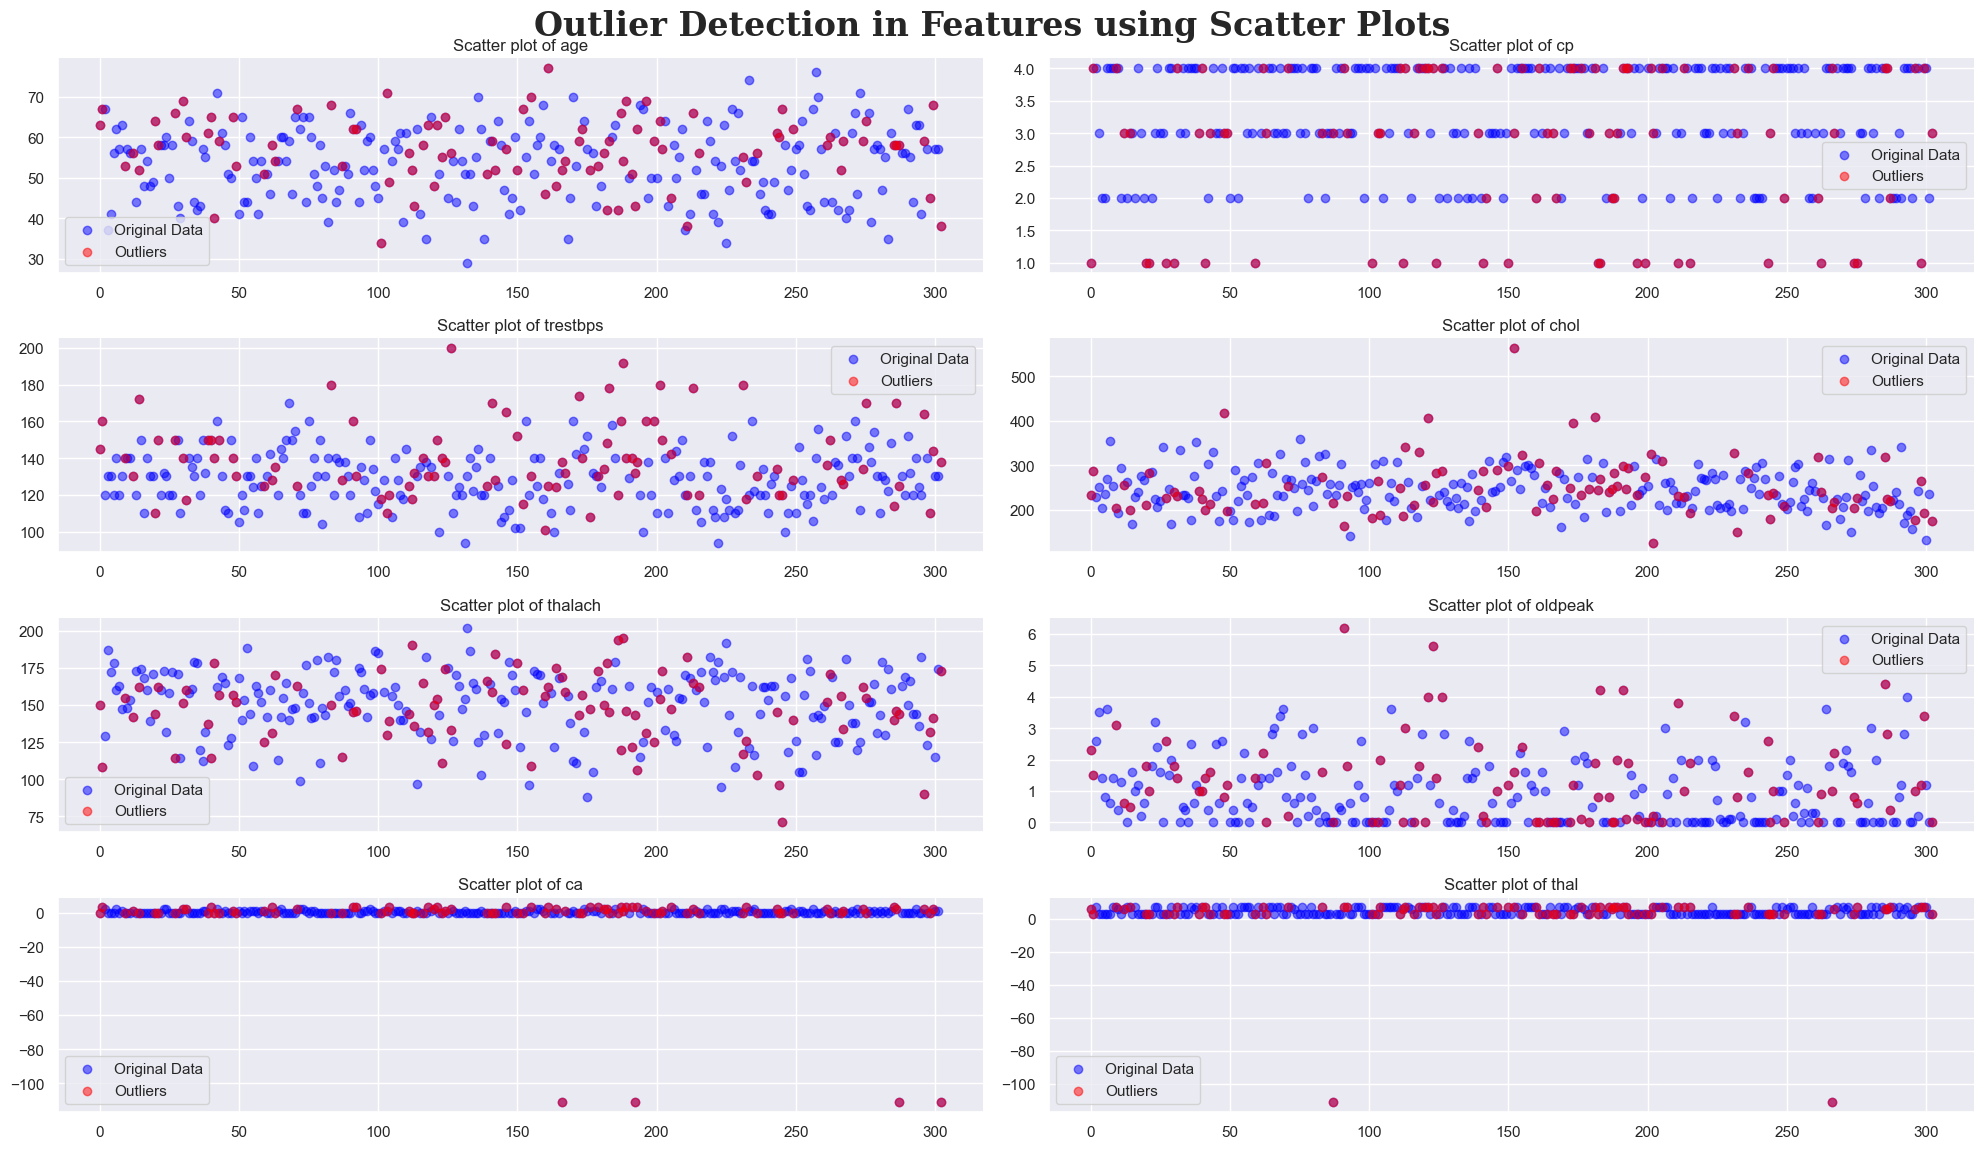

In [66]:
from sklearn.ensemble import IsolationForest


def detect_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df < lower_bound) | (df > upper_bound)).any(axis=1)
    return outliers


def outliers_detect_with_isolationForest(df, contamination=0.05, random_state=config.SEED):
    model = IsolationForest(contamination=contamination, random_state=random_state)

    outliers = model.fit_predict(df)
    # Convert outliers to boolean array
    outliers = outliers == -1

    return outliers
    

# Detect outliers
outliers = detect_outliers(df)
outliers_with_IF = outliers_detect_with_isolationForest(df)

# Remove outliers
df_cleaned = df[~outliers]
df_cleaned_with_IF = df[~outliers_with_IF]
# Potting the graph
plt.figure(figsize=(20, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(7, 2, i)
    plt.scatter(df.index, df[feature], label='Original Data', color='blue', alpha=0.5)
    plt.scatter(df[outliers].index, df[outliers][feature], label='Outliers', color='red', alpha=0.5)
    plt.title(f'Scatter plot of {feature}')
    sns.despine(right=True, top=True)
    plt.legend()

plt.suptitle("Outlier Detection in Features using Scatter Plots", fontsize=24, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

In [71]:
def remove_outliers_modified_zscore(df, threshold=3.5):
    if 'class' in df.columns:
        data_without_class = df.drop(columns=['class'])
        median = data_without_class.median()
        median_absolute_deviation = (data_without_class - median).abs().median()
        modified_z_scores = 0.6745 * (data_without_class - median) / median_absolute_deviation
        outliers = (modified_z_scores > threshold) | (modified_z_scores < -threshold)
        # Append 'class' column back to the DataFrame after outlier removal
        cleaned_df = pd.concat([df['class'], data_without_class[~outliers.any(axis=1)]], axis=1)
        return outliers, cleaned_df
    else:
        raise ValueError("No 'class' column found in DataFrame.")

# Apply outlier removal function
new_outliers, new_df = remove_outliers_modified_zscore(df)
# Count the occurrences of each class in the cleaned DataFrame
new_df['class'].value_counts()


class
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

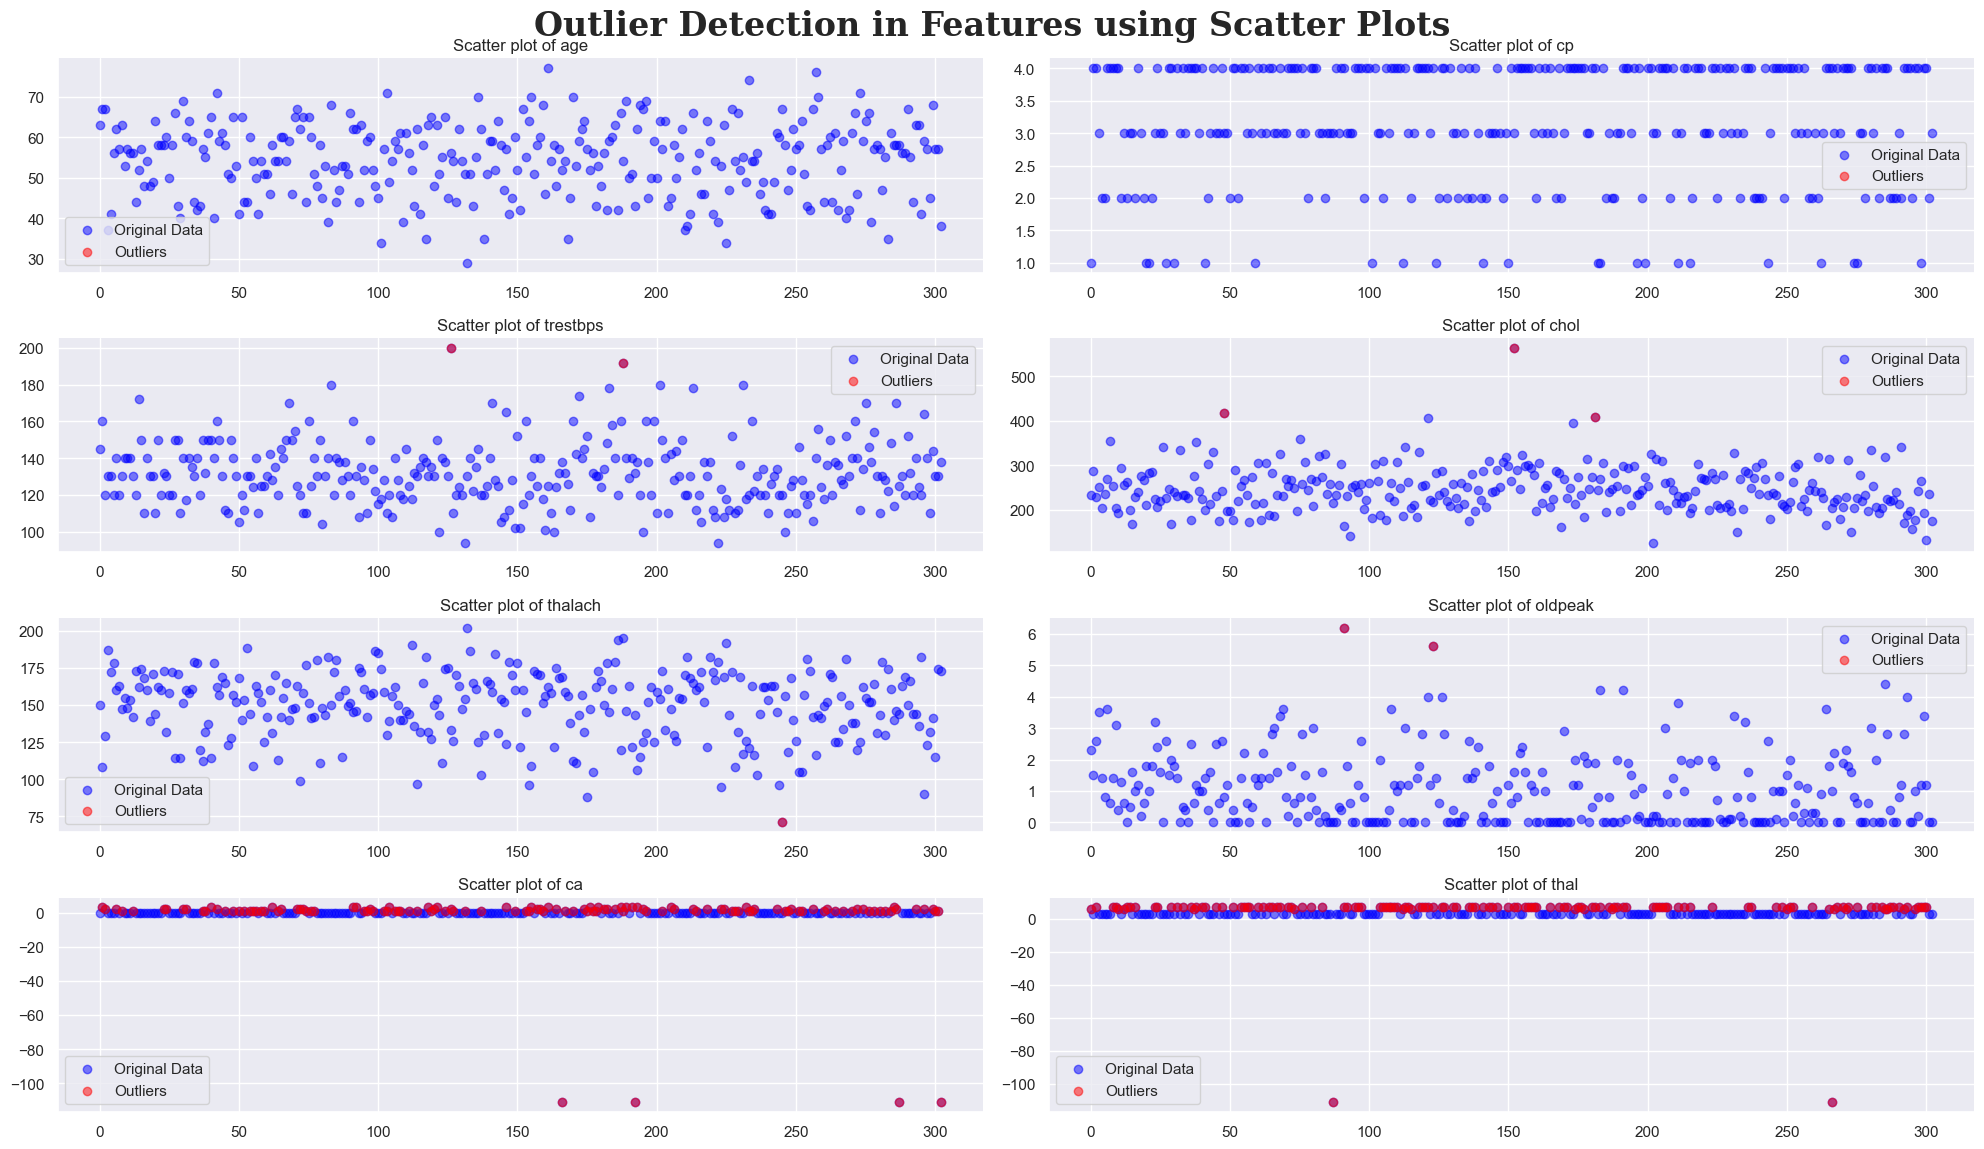

In [72]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(7, 2, i)
    plt.scatter(df.index, df[feature], label='Original Data', color='blue', alpha=0.5)
    plt.scatter(df[new_outliers].index, df[new_outliers][feature], label='Outliers', color='red', alpha=0.5)
    plt.title(f'Scatter plot of {feature}')
    sns.despine(right=True, top=True)
    plt.legend()

plt.suptitle("Outlier Detection in Features using Scatter Plots", fontsize=24, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

In [59]:
def outliers_plot(df, outliers, cleaned_df,  features):
  plt.figure(figsize=(20, 20))
  for i, feature in enumerate(features):
      # Orginal dataset with outliers
      plt.subplot(7, 2, 2 * i + 1)
      plt.scatter(df.index, df[feature], label='Original Data', color='blue', alpha=0.5)
      plt.scatter(df[outliers].index, df[outliers][feature], label='Outliers', color='red', alpha=0.5)
      plt.title(f'Scatter plot of {feature} (Original)')
      plt.legend()
      
      # Cleaned data wihtout outliers
      plt.subplot(7, 2, 2 * i + 2)
      plt.scatter(cleaned_df.index, cleaned_df[feature], label='Cleaned Data', color='green', alpha=0.5)
      plt.title(f'Scatter plot of {feature} (Cleaned)')
      plt.legend()

  plt.tight_layout()
  plt.show()

outliers_plot(df,new_outliers, new_df,features)

ValueError: num must be an integer with 1 <= num <= 14, not 15

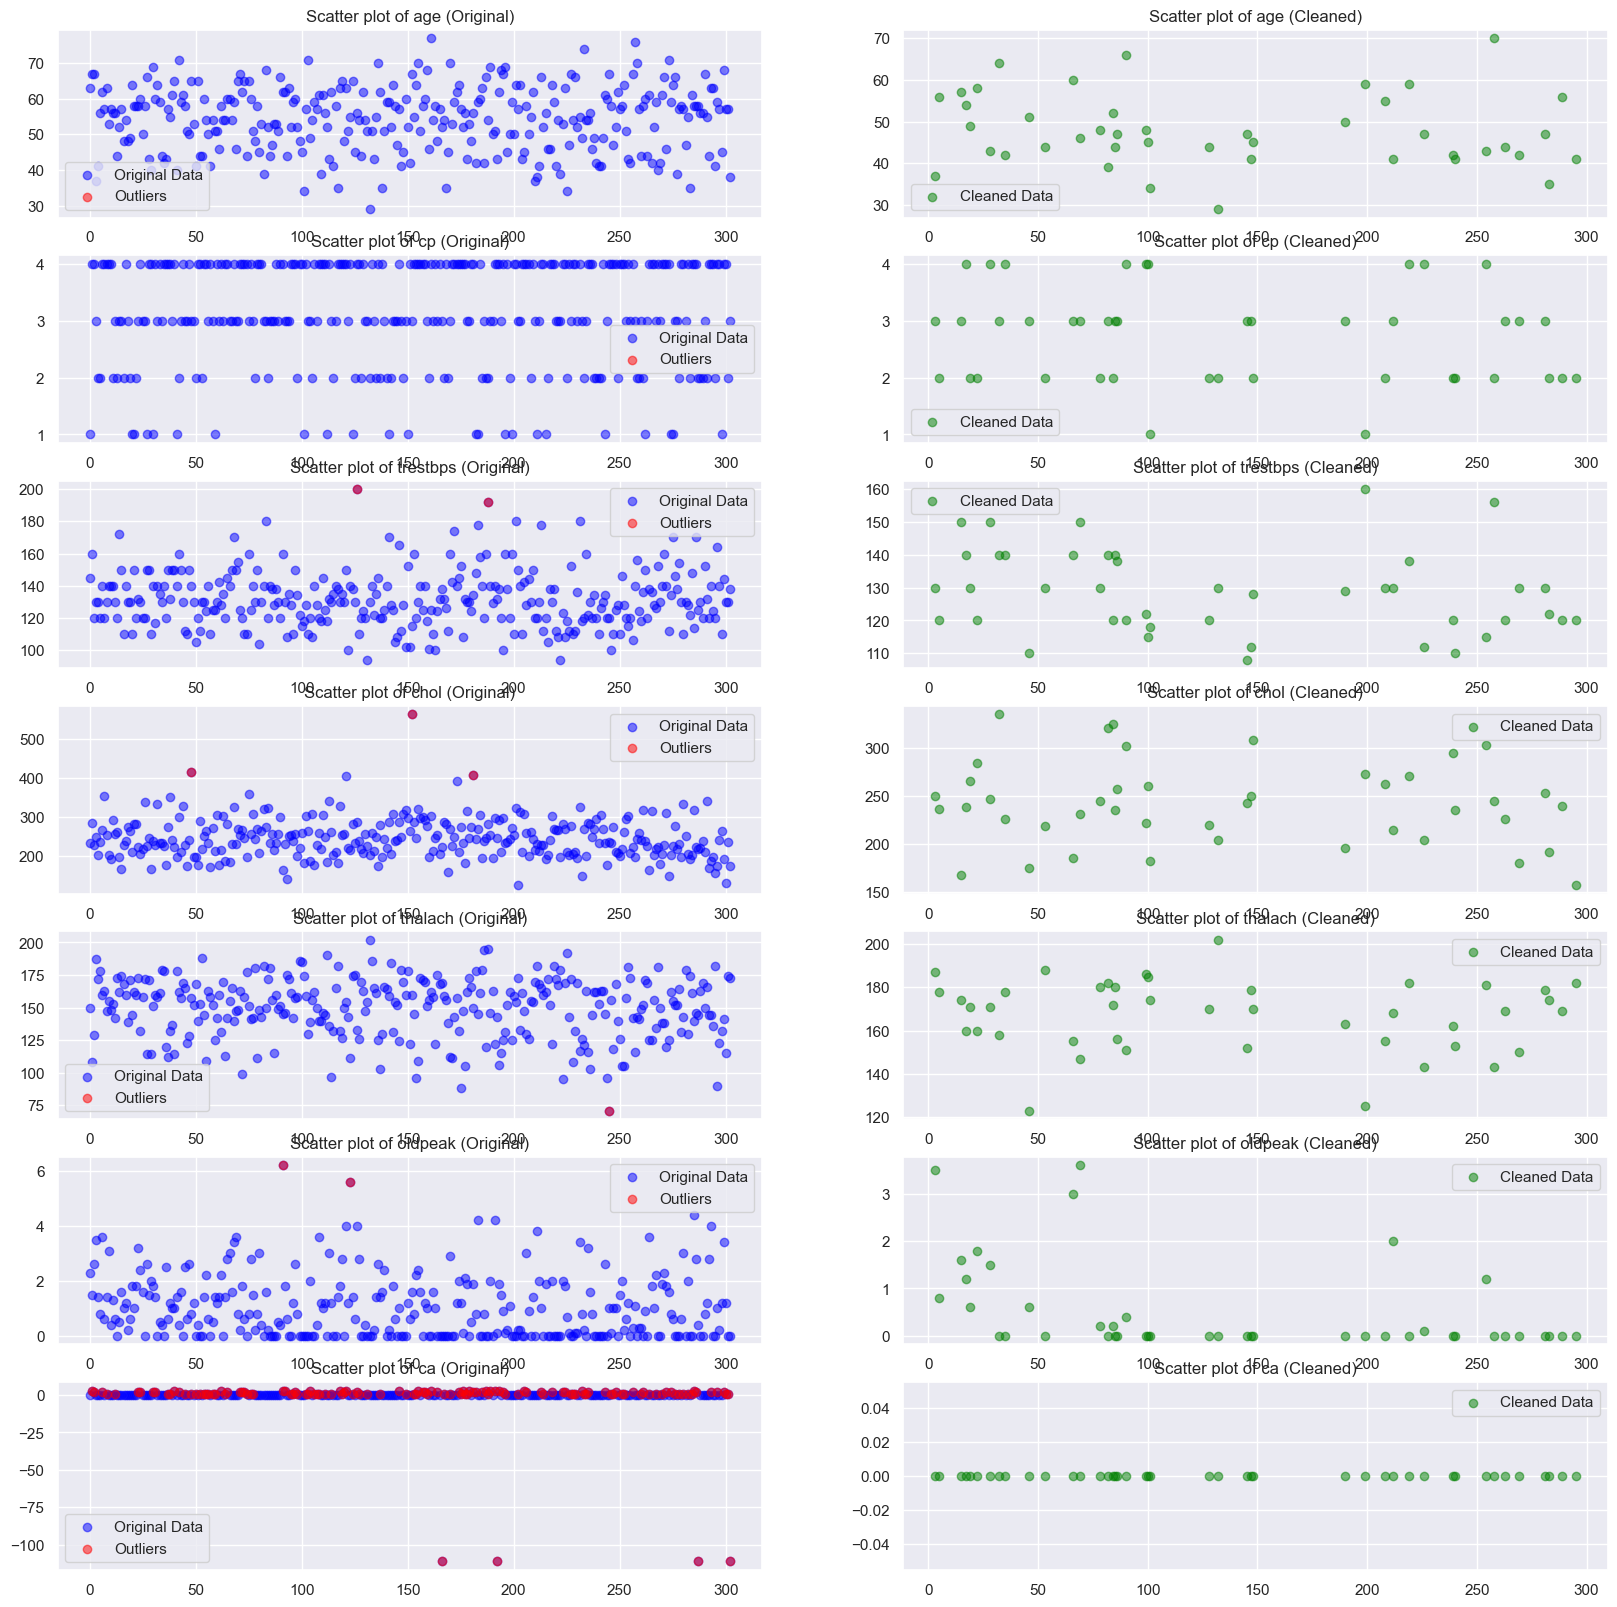

In [73]:
outliers_plot(df,new_outliers, new_df,features)

In [74]:
new_df.to_csv("../data/clean_data/first_cleaned.csv")

In [75]:
new_df['class'].value_counts()

class
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [3]:
fold_df = pd.read_csv('../data/clean_data/train_fold.csv')
fold_df.skfold.value_counts()

skfold
2    61
1    61
0    61
4    60
3    60
Name: count, dtype: int64

In [4]:
data  = fold_df.groupby('skfold')['class'].agg({'value_counts'}).reset_index()   
data

,skfold,class,value_counts
0,0,0,33
1,0,1,11
2,0,2,7
3,0,3,7
4,0,4,3
5,1,0,33
6,1,1,11
7,1,2,7
8,1,3,7
9,1,4,3


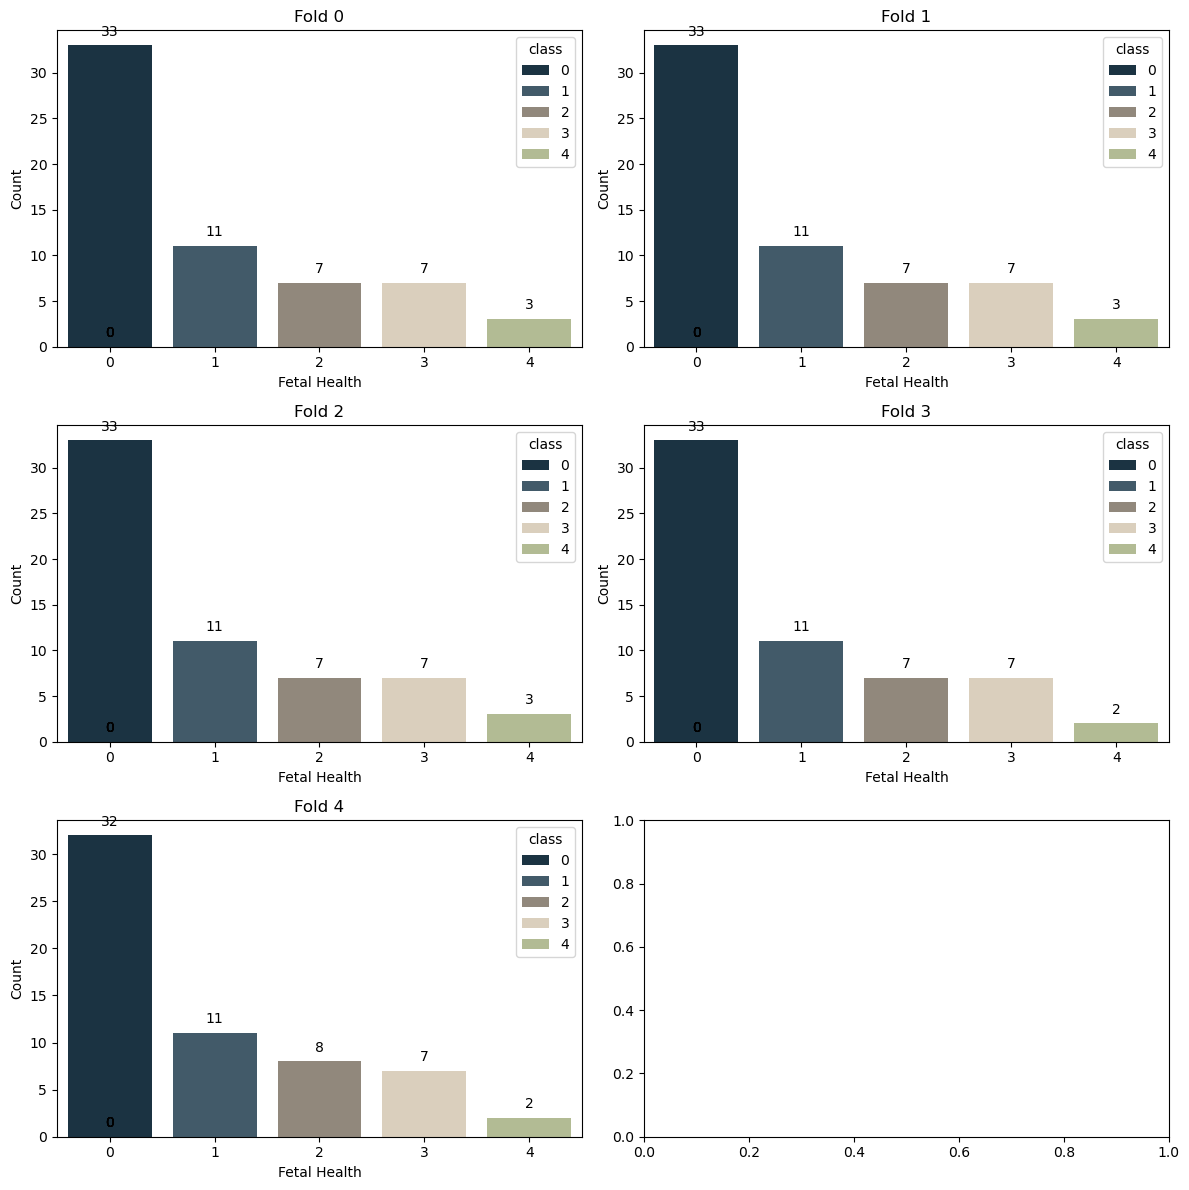

In [10]:
colors = ["#153448", "#3C5B6F","#948979", "#DFD0B8", "#B5C18E"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    fold_data = data[data['skfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='class', y='value_counts', ax=ax, palette=colors, hue='class')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')
        
    else:
        break

plt.tight_layout()
plt.savefig("../plots/folds_class.jpg")
plt.show()

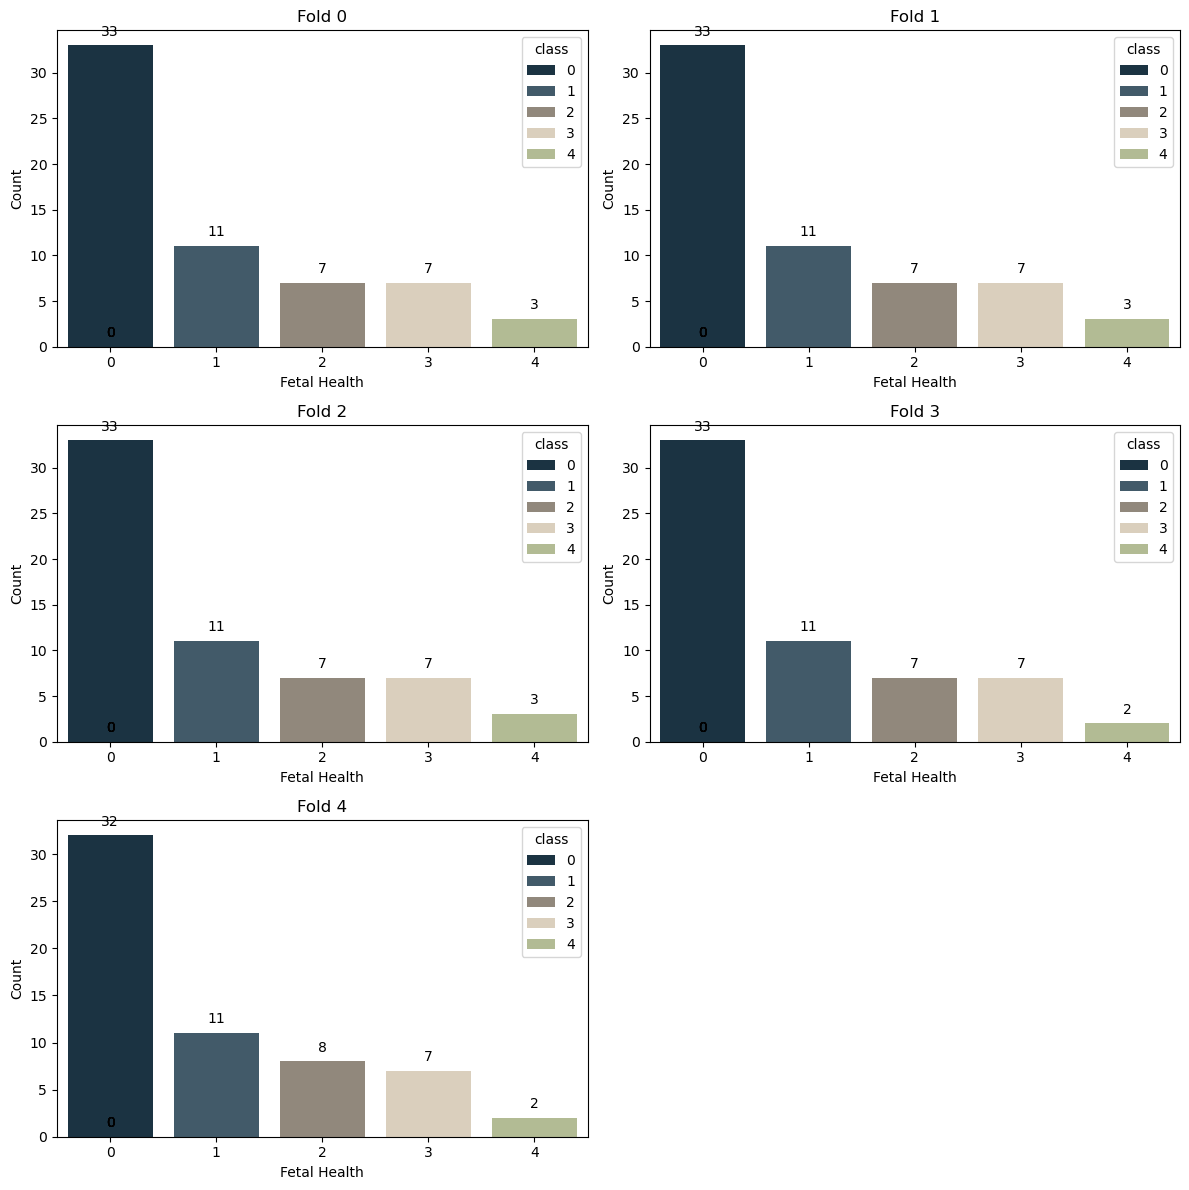

In [9]:
# Create subplots dynamically based on data availability
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over folds and create plots
for i, ax in enumerate(axes):
    fold_data = data[data['skfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='class', y='value_counts', ax=ax, palette=colors, hue='class')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points')
    else:
        # Remove unused subplot
        fig.delaxes(ax)

# Adjust layout and save/show plot
plt.tight_layout()
plt.savefig("../plots/folds_class.jpg")
plt.show()

### <center><b><u><span style="color:#ff6600">OBSERVATIONS✍️</span></u></b></center>

* In each `fold`, there is a noticeable class imbalance between all classes. The "0" class appears more frequently than the other class.

* It seems like after using `StratifiedKFold` to create your folds, our target classes are distributed badly I would say. However, if the majority class (class 0) is significantly larger than the minority classes (classes 1,2,3 and 4.0), we still end up with `imbalanced folds`.

**`we might want to consider techniques such as class weighting, `resampling method`s (e.g., `oversampling` the minority class), or using `evaluation metrics` that are sensitive to class imbalance to ensure that our model effectively learns from both classes and generalizes well`**

---

# <center>`Lets understand **Undersampling** and **Oversampling**`</center>

**Oversampling:** In oversampling, you increase the number of instances of the minority class (in our case, "CHURN") to balance the class distribution. This can be done using techniques like `SMOTE (Synthetic Minority Over-sampling Technique)`, `ADASYN (Adaptive Synthetic Sampling)`, or simply by duplicating instances from the minority class.

**Undersampling:** In undersampling, you decrease the number of instances of the majority class (in this case, "ACTIVE") to balance the class distribution. This can involve randomly removing instances from the majority class until a more balanced distribution is achieved.

<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*7xf9e1EaoK5n05izIFBouA.png" alt="Image" />
</div>


<hr><hr>

### <b><u><span style="color:#ff6600">Each technique has its own set of advantages and disadvantages:</span></u></b></center></span></u></b>
#### `Undersampling:`

**Pros:**

- **`Reduces Training Time`**: By reducing the number of instances in the majority class, undersampling can significantly decrease training time, especially for algorithms sensitive to large datasets.
- **`Simplifies Model Interpretation`**: With a more balanced dataset, models may be simpler and easier to interpret, as they don't need to learn the nuances of the majority class as extensively.
- **`May Improve Performance on the Minority Class`**: By focusing more on the minority class, models trained on undersampled data may achieve higher precision, recall, or other performance metrics for the minority class.

**Cons:**

- **`Information Loss`**: Removing instances from the majority class can lead to the loss of potentially valuable information, which may degrade the model's ability to generalize to unseen data.
- **`Risk of Overfitting`**: Undersampling may increase the risk of overfitting, particularly if the dataset is already limited in size.
- **`Biased Representation`**: The reduced representation of the majority class may not accurately reflect its true distribution, leading to biased model predictions.

<hr>

#### `Oversampling:`

**Pros:**

- **`Preserves Information`**: Oversampling techniques generate synthetic samples or replicate existing minority class instances, preserving information from the minority class and potentially improving model performance.
- **`Balances Class Distribution`**: By increasing the representation of the minority class, oversampling can help balance the class distribution, reducing bias in model predictions.
- **`Reduces Risk of Overfitting`**: Oversampling increases the amount of training data available to the model, which can reduce the risk of overfitting, especially in cases of severe class imbalance.

**Cons:**

- **`Potential Overfitting`**: Oversampling can introduce synthetic data points that may not accurately represent the true distribution of the minority class, leading to overfitting, especially if not carefully implemented.
- **`Increased Computational Cost`**: Generating synthetic samples or replicating minority class instances can increase computational cost, especially for large datasets.
- **`Model Sensitivity`**: Some oversampling techniques may introduce noise or patterns that are not representative of the underlying data distribution, potentially leading to decreased model performance.

<hr><hr>




In [ ]:
df = pd.read_csv(config.CLEAN_FILE)
df.head()

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mlxtend as ml
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.math import num_combinations
from mlxtend.regressor import StackingRegressor

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

df.dropna(axis=0, inplace=True)
X_new = df.drop('class', axis=1)
y_new = df['class']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.20, random_state=config.SEED)

scaler = QuantileTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression()

In [102]:
X_new.shape[1]

13

In [103]:

sfs1 = SFS(
  lr,
  k_features=13,
  forward=True,
  floating=True,
  verbose=2,
  scoring='accuracy',
  cv=5,
  n_jobs=-1
)

sfs1 = sfs1.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2024-06-09 18:23:25] Features: 1/13 -- score: 0.5621598639455783[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2024-06-09 18:23:26] Features: 2/13 -- score: 0.599234693877551[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)

In [104]:
sfs1.subsets_

{1: {'feature_idx': (11,),
  'cv_scores': array([0.53061224, 0.55102041, 0.5625    , 0.5625    , 0.60416667]),
  'avg_score': 0.5621598639455783,
  'feature_names': ('11',)},
 2: {'feature_idx': (11, 12),
  'cv_scores': array([0.57142857, 0.6122449 , 0.60416667, 0.58333333, 0.625     ]),
  'avg_score': 0.599234693877551,
  'feature_names': ('11', '12')},
 3: {'feature_idx': (5, 11, 12),
  'cv_scores': array([0.57142857, 0.6122449 , 0.60416667, 0.58333333, 0.66666667]),
  'avg_score': 0.6075680272108843,
  'feature_names': ('5', '11', '12')},
 4: {'feature_idx': (5, 9, 11, 12),
  'cv_scores': array([0.59183673, 0.6122449 , 0.625     , 0.58333333, 0.625     ]),
  'avg_score': 0.6074829931972789,
  'feature_names': ('5', '9', '11', '12')},
 5: {'feature_idx': (5, 7, 9, 11, 12),
  'cv_scores': array([0.63265306, 0.6122449 , 0.60416667, 0.58333333, 0.625     ]),
  'avg_score': 0.6114795918367347,
  'feature_names': ('5', '7', '9', '11', '12')},
 6: {'feature_idx': (0, 3, 7, 9, 11, 12),
  'c

In [105]:
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95)
metric_df = pd.DataFrame.from_dict(metric_dict).T
metric_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[0.5306122448979592, 0.5510204081632653, 0.562...",0.56216,"(11,)",0.030869,0.024017,0.012009
2,"(11, 12)","[0.5714285714285714, 0.6122448979591837, 0.604...",0.599235,"(11, 12)",0.024946,0.019409,0.009704
3,"(5, 11, 12)","[0.5714285714285714, 0.6122448979591837, 0.604...",0.607568,"(5, 11, 12)",0.042315,0.032923,0.016461
4,"(5, 9, 11, 12)","[0.5918367346938775, 0.6122448979591837, 0.625...",0.607483,"(5, 9, 11, 12)",0.021996,0.017114,0.008557
5,"(5, 7, 9, 11, 12)","[0.6326530612244898, 0.6122448979591837, 0.604...",0.61148,"(5, 7, 9, 11, 12)",0.022094,0.017189,0.008595
6,"(0, 3, 7, 9, 11, 12)","[0.6326530612244898, 0.6326530612244898, 0.583...",0.615561,"(0, 3, 7, 9, 11, 12)",0.024668,0.019193,0.009596
7,"(0, 2, 3, 7, 9, 11, 12)","[0.5918367346938775, 0.6122448979591837, 0.645...",0.61165,"(0, 2, 3, 7, 9, 11, 12)",0.023514,0.018294,0.009147
8,"(0, 2, 3, 7, 9, 10, 11, 12)","[0.6326530612244898, 0.6122448979591837, 0.666...",0.63648,"(0, 2, 3, 7, 9, 10, 11, 12)",0.023925,0.018614,0.009307
9,"(0, 3, 5, 6, 8, 9, 10, 11, 12)","[0.6326530612244898, 0.6326530612244898, 0.666...",0.640561,"(0, 3, 5, 6, 8, 9, 10, 11, 12)",0.018859,0.014673,0.007337
10,"(0, 2, 3, 5, 6, 8, 9, 10, 11, 12)","[0.6122448979591837, 0.6530612244897959, 0.645...",0.636395,"(0, 2, 3, 5, 6, 8, 9, 10, 11, 12)",0.019653,0.015291,0.007645


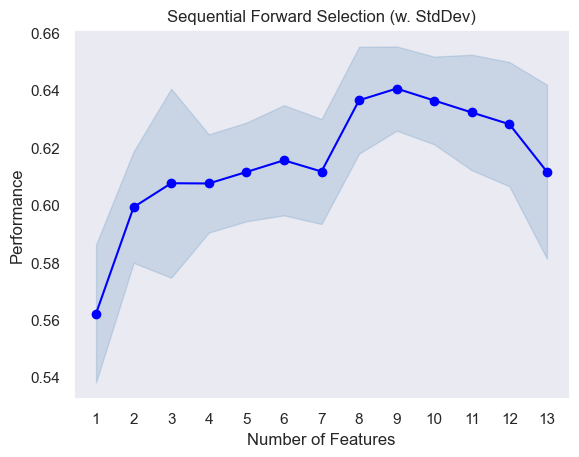

In [106]:
fig1 = plot_sfs(metric_dict, kind='std_dev')
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid(False)

In [107]:
all_comb = np.sum([num_combinations(n=X_new.shape[1], k=i) for i in range(1, X_new.shape[1]+1)])
all_comb
efs1 = EFS(lr,
           min_features=1,
           max_features=13,
           scoring='accuracy',
           print_progress=True,
           n_jobs=-1,
           cv=5)

efs1 = efs1.fit(X_train_scaled, y_train)
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 8191/8191

Best accuracy score: 0.64
Best subset (indices): (0, 2, 3, 5, 8, 10, 11)
Best subset (corresponding names): ('0', '2', '3', '5', '8', '10', '11')


In [108]:
df = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4641,"(0, 2, 3, 5, 8, 10, 11)","[0.6122448979591837, 0.6938775510204082, 0.645...",0.644558,"(0, 2, 3, 5, 8, 10, 11)",0.035722,0.027793,0.013897
7581,"(0, 3, 5, 6, 8, 9, 10, 11, 12)","[0.6326530612244898, 0.6326530612244898, 0.666...",0.640561,"(0, 3, 5, 6, 8, 9, 10, 11, 12)",0.018859,0.014673,0.007337
3988,"(3, 5, 8, 10, 11, 12)","[0.6122448979591837, 0.6530612244897959, 0.666...",0.640561,"(3, 5, 8, 10, 11, 12)",0.034706,0.027002,0.013501
4647,"(0, 2, 3, 5, 10, 11, 12)","[0.6530612244897959, 0.6326530612244898, 0.645...",0.640476,"(0, 2, 3, 5, 10, 11, 12)",0.013063,0.010164,0.005082
6397,"(0, 2, 3, 7, 9, 10, 11, 12)","[0.6326530612244898, 0.6122448979591837, 0.666...",0.63648,"(0, 2, 3, 7, 9, 10, 11, 12)",0.023925,0.018614,0.009307
...,...,...,...,...,...,...,...
1183,"(0, 1, 4, 6, 10)","[0.5510204081632653, 0.5510204081632653, 0.541...",0.528741,"(0, 1, 4, 6, 10)",0.045566,0.035452,0.017726
2509,"(0, 1, 3, 4, 6, 10)","[0.5510204081632653, 0.5714285714285714, 0.520...",0.528656,"(0, 1, 3, 4, 6, 10)",0.049797,0.038744,0.019372
1185,"(0, 1, 4, 6, 12)","[0.5510204081632653, 0.5102040816326531, 0.458...",0.524745,"(0, 1, 4, 6, 12)",0.048174,0.037481,0.018741
4320,"(0, 1, 3, 4, 5, 9, 10)","[0.5510204081632653, 0.5510204081632653, 0.5, ...",0.524575,"(0, 1, 3, 4, 5, 9, 10)",0.03794,0.029518,0.014759


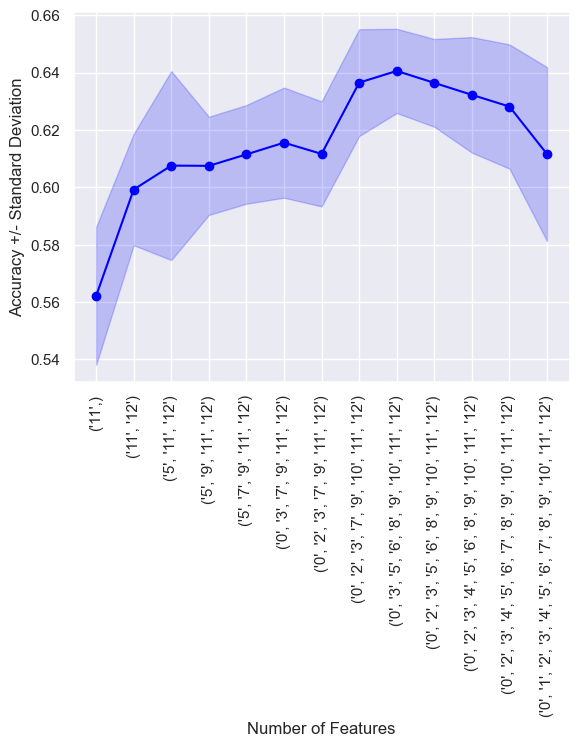

In [109]:
etric_dict = efs1.get_metric_dict()

fig = plt.figure()
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

plt.plot(k_feat, avg, color='blue', marker='o')
plt.ylabel('Accuracy +/- Standard Deviation')
plt.xlabel('Number of Features')
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
plt.xticks(k_feat, 
           [str(metric_dict[k]['feature_names']) for k in k_feat], 
           rotation=90)
plt.show()